In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append('../../tools')
from dust_extinction import calALambda
from data_binning import data_binning

z = 0.0307
t_max = 2458986.91
t_max_mjd = t_max - 2400000.5
ebv = 0.404
rv = 3.1

In [49]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [6]:
col = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33',
    '#a65628'
]

In [136]:
import glob
spec_files = glob.glob('../../spectroscopy/ZTF20aayhacx*ascii')
spec_files.sort()
spec_He_files = [s for s in spec_files if (('Keck' in s) or ('GNIRS' in s))]

In [23]:
spec_files

['../../spectroscopy/ZTF20aayhacx_20200507_P60_v2.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200513_NOT_v4.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200521_P60_v2.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200528_P60_v2.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200529_Lick_3-m_v1.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200608_P60_v2.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200609_GNIRS.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200610_P200_v2.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200623_Keck1_v1.ascii',
 '../../spectroscopy/ZTF20aayhacx_20200915_Keck1_v2.ascii',
 '../../spectroscopy/ZTF20aayhacx_20201020_Keck1_v1.ascii']

# Compare Lines

In [5]:
def velocity_rf(lambda_rf, lambda_0):
    '''convert rest-frame wavelength to relative velocity'''
    c = 2.99792458e5
    v = c * ((lambda_rf / lambda_0)**2 - 1) / ((lambda_rf / lambda_0)**2 + 1)

    return v

In [172]:
def compare_lines(spec_files,
                  ax,
                  line=10830,
                  vmax=-30000,
                  vmin=0,
                  norm_fac=1,
                  bin_size=100,
                  phase_min=-np.inf,
                  phase_max=np.inf,
                  col=[]):
    '''Compare the line regions in velocity space
    '''

    from data_binning import data_binning, plot_box_spec
    from astropy.time import Time
    
    spec_num = -1
    for spec in spec_files:
        if 'P60' in spec:
            continue
        with open(spec) as f:
            ll = f.readlines()
        # brute force
        mjd_found = False
        for l in ll:
            if 'MJD' in l:
                mjd_found = True
                if '=' in l and 'at start' in l:
                    mjd_obs = float(l.split('=')[1].split("'")[1])
                elif '=' in l and '/' in l:
                    mjd_obs = float(l.split('=')[1].split('/')[0])
                elif '=' in l:
                    mjd_obs = float(l.split('=')[1])
                elif ':' in l:
                    mjd_obs = float(l.split(':')[1])
                break
        if not mjd_found:
            #print('Warning: MJD-obs not found in {}!'.format(spec))
            #print('Try the observation date.')
            year = 2020
            pos_dat = spec.find(str(year))
            year_obs = spec[pos_dat:pos_dat + 4]
            mon_obs = spec[pos_dat + 4:pos_dat + 6]
            date_obs = spec[pos_dat + 6:pos_dat + 8]
            mjd_obs = Time('{}-{}-{}'.format(year_obs, mon_obs, date_obs)).mjd
        phase = (mjd_obs - t_max_mjd) / (1 + z)
        if (phase < phase_min) or (phase > phase_max):
            continue
        spec_num += 1
        spec_df = pd.read_csv(spec,
                          comment='#',
                          delim_whitespace=True,
                          header=None)

        try:
            if 'Keck' in spec:
                fl_unc0 = spec_df[3].values
            else:
                fl_unc0 = spec_df[2].values

                if 'P60' in spec or 'P200' in spec:
                    fl_unc0 **= .5
        except:
            # set relative uncertainty to be 10%
            fl_unc0 = np.ones_like(spec_df[0].values) * 1e-1 * np.median(
                spec_df[0].values)

        wv0, fl0 = spec_df[0].values / (1 + z), spec_df[1].values
        E0 = 10**(0.4 * calALambda(wv0, rv, ebv))
        norm = fl0[np.abs(wv0 - 8500) < 500].mean()
        fl0 *= E0 / norm
        fl_unc0 *= E0 / norm
        vel_rf0 = velocity_rf(wv0, line)

        out = data_binning(np.array([vel_rf0, fl0, fl_unc0]).T, size=bin_size)
        vel_rf_bin, fl_bin = plot_box_spec(out[:, 0], out[:, 1])
        vel_rf, fl = plot_box_spec(vel_rf0, fl0)
        fl_unc = np.repeat(fl_unc0, 2)

        if len(col) == 0:
            col = np.repeat([None], len(spec_files))

        if phase < 0:
            label = r'$-{:.1f}$'.format(np.abs(phase))
        else:
            label = r'$+{:.1f}$'.format(np.abs(phase))

        if phase > 22:
            h = 1.5
        else:
            h = 1
        ax.plot(vel_rf_bin / 1000, fl_bin / norm_fac - spec_num * h, color=col[spec_num])
        ax.plot(vel_rf / 1000, fl / norm_fac - spec_num * h, alpha=0.3, color=col[spec_num])
        ax.text(vmin / 1000, fl[np.argmin(np.abs(vel_rf - vmin))] / norm_fac - spec_num * h, label, color='k')
        ax.set_xlim(vmax / 1000, vmin / 10000)
        #plt.fill_between(vel_rf,
        #                 fl - fl_unc, fl + fl_unc,
        #                 alpha=0.5, color=col[k + displace])
    ax.set_xlabel('$v\ [10^3\ \mathrm{km/s}]$')
    ax.set_yticks([])

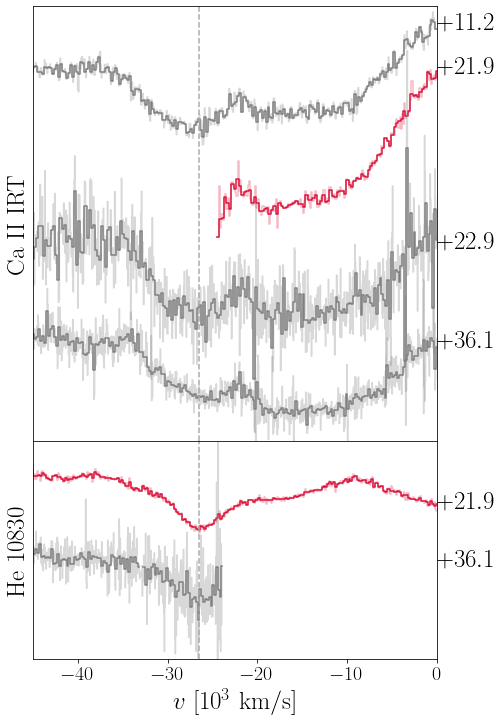

In [180]:
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.75,
                      hspace=0, wspace=0.05)
ax0 = fig.add_subplot(gs[:-1, :])
ax1 = fig.add_subplot(gs[-1, :])

Ca_II_IRT = 8662.140
col_Ca = ['grey', 'crimson', 'grey', 'grey', 'grey']
compare_lines(spec_files, ax0, line=Ca_II_IRT, vmax=-45000, vmin=0, phase_min=11, phase_max=37, norm_fac=1.2, bin_size=200, col=col_Ca)
ax0.set_ylim(-4, 2.4)
ax0.set_xticks([])
ax0.set_xlabel('')
ax0.set_ylabel(r'$\mathrm{Ca\ II\ IRT}$')

HeI = 10830
col_He = ['crimson', 'grey']
compare_lines(spec_He_files, ax1, line=HeI, vmax=-45000, vmin=0, phase_min=11, phase_max=37, norm_fac=1.2, bin_size=200, col=col_He)
ax1.set_ylim(-2, 2)
ax1.set_ylabel(r'$\mathrm{He}\ 10830$')

ax0.axvline(-26.5, color='darkgrey', linestyle='--')
ax1.axvline(-26.5, color='darkgrey', linestyle='--')